# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

https://github.com/petrobras/3W

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

In [2]:
df = pd.read_parquet('real_instances.parquet.gzip') 

In [3]:
df.shape

(14516197, 12)

In [4]:
df.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,NaN,0.0,0.0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,NaN,0.0,0.0


### Análise inicial

In [5]:
df.id.nunique()

1013

In [6]:
df['label'].value_counts()

label
0    9903155
4    2462076
3     569152
5     552529
7     466338
1     312136
2     194233
6      56578
Name: count, dtype: int64

In [7]:
df['class'].value_counts()

class
0.0      10003293
4.0       2462076
3.0        569152
105.0      317565
107.0      283262
101.0       95658
102.0       65130
7.0         25870
2.0         16100
5.0         13031
6.0         12951
1.0         10417
106.0        6252
Name: count, dtype: int64

In [8]:
pd.crosstab(df['well'], df['label'])

label,0,1,2,3,4,5,6,7
well,,,,,,,,
WELL-00001,1652442,58468,0,17976,261457,0,0,73033
WELL-00002,3641159,24017,9121,0,807601,0,47869,0
WELL-00003,463543,0,35406,0,0,0,0,0
WELL-00004,85505,0,0,0,307674,0,8709,0
WELL-00005,979611,0,0,0,271525,0,0,0
WELL-00006,2058403,229651,0,0,0,0,0,305517
WELL-00007,14370,0,0,0,71651,0,0,0
WELL-00008,1008122,0,0,0,0,0,0,0
WELL-00009,0,0,6738,0,0,0,0,0


In [9]:
pd.crosstab(df['class'], df['label'])

label,0,1,2,3,4,5,6,7
class,,,,,,,,
0.0,9439612,195376,52017,0,0,127930,36319,152039
1.0,0,10417,0,0,0,0,0,0
2.0,0,0,16100,0,0,0,0,0
3.0,0,0,0,569152,0,0,0,0
4.0,0,0,0,0,2462076,0,0,0
5.0,0,0,0,0,0,13031,0,0
6.0,0,0,0,0,0,0,12951,0
7.0,0,0,0,0,0,0,0,25870
101.0,0,95658,0,0,0,0,0,0


In [10]:
df.drop_duplicates(subset=['id'], keep='last').groupby("label")["id"].count()

label
0    588
1      5
2     22
3     32
4    344
5     11
6      6
7      5
Name: id, dtype: int64

In [11]:
df.isnull().sum()/len(df)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000580
P-TPT         0.008007
T-TPT         0.008007
P-MON-CKP     0.077959
T-JUS-CKP     0.113279
P-JUS-CKGL    0.071501
T-JUS-CKGL    1.000000
QGL           0.191125
class         0.043775
dtype: float64

In [12]:
df['target'] = 1
df.loc[(df['label']==0)&(df['class']==0), "target"] = 0

In [13]:
df.target.value_counts()

target
0    9439612
1    5076585
Name: count, dtype: int64

In [14]:
df.target.value_counts(normalize=True)

target
0    0.650281
1    0.349719
Name: proportion, dtype: float64

In [15]:
df2 = df.drop(['T-JUS-CKGL'], axis=1)
df2 = df2.dropna()

In [16]:
del df

In [17]:
df2.shape

(11108977, 12)

In [18]:
df2.target.value_counts(normalize=True)

target
0    0.663057
1    0.336943
Name: proportion, dtype: float64

In [19]:
df3 = df2.reset_index()
df3.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
0,2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
1,2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2,2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
3,2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
4,2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [20]:
df3['well'].value_counts()

well
WELL-00002    4518972
WELL-00006    2588359
WELL-00001    2062763
WELL-00014     699734
WELL-00010     601704
WELL-00017     382288
WELL-00018      87162
WELL-00007      86021
WELL-00015      54811
WELL-00016      20465
WELL-00009       6698
Name: count, dtype: int64

### Modelagem

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

In [47]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred))  

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print("Specificity:", TN/(TN+FP))
    
    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [23]:
df2.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class,target
timestamp,,,,,,,,,,,,
2017-02-01 02:02:07,0,WELL-00001,20170201020207,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0.0,0
2017-02-01 02:02:08,0,WELL-00001,20170201020207,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0.0,0
2017-02-01 02:02:09,0,WELL-00001,20170201020207,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0.0,0
2017-02-01 02:02:10,0,WELL-00001,20170201020207,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0.0,0
2017-02-01 02:02:11,0,WELL-00001,20170201020207,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0.0,0


In [24]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']
data = df2[VARS]
data['target'] = df2['target']

In [25]:
data.reset_index(drop=True, inplace=True)

In [26]:
data.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
0,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,0.0,0
1,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,0.0,0
2,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,0.0,0
3,0.0,10091780.0,119.0944,1635018.0,84.57429,1564148.0,0.0,0
4,0.0,10091670.0,119.0944,1643424.0,84.56644,1564148.0,0.0,0


In [27]:
data.dtypes

P-PDG         float64
P-TPT         float64
T-TPT         float64
P-MON-CKP     float64
T-JUS-CKP     float64
P-JUS-CKGL    float64
QGL           float64
target          int64
dtype: object

In [30]:
X_all = data[VARS]
y_all = data['target']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.30 , stratify=y_all, random_state = 7265)

print('Numero de observaçoes do treino:', len(X_train))
print('Numero de observaçoes da teste:',len(X_test))

Numero de observaçoes do treino: 7776283
Numero de observaçoes da teste: 3332694


In [33]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train)#.reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test)#.reset_index(drop=True) 

In [34]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
1136940,0.0,14105330.0,116.52030,5935994.0,69.98248,3.304309e+06,0.000000,0
9597311,23825720.0,15657980.0,57.89000,6399457.0,35.43812,1.753477e+09,1.374636,1
10521370,32308910.0,6580685.0,99.77296,2447997.0,46.31764,1.657173e+07,0.000000,1
1550599,-6887865.0,9640549.0,118.53250,1703513.0,83.98549,-1.475654e+05,0.000000,0
9212091,0.0,16107570.0,117.92650,7244855.0,173.09610,4.305292e+06,0.000000,1


In [35]:
train.target.value_counts()

target
0    5156118
1    2620165
Name: count, dtype: int64

In [36]:
train.to_parquet('train.parquet.gzip',
              compression='gzip')

test.to_parquet('test.parquet.gzip',
              compression='gzip')

In [37]:
X_train.describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
count,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06
mean,-3.772303e+40,2.786910e+07,1.082510e+02,4.574487e+06,7.466969e+01,1.133788e+08,1.670137e-01
std,2.075922e+41,2.052705e+08,2.157421e+01,3.595516e+06,3.277477e+01,4.257401e+08,4.545855e-01
min,-1.180116e+42,4.488939e+06,7.236000e+00,7.531268e+05,-2.020000e+00,-4.976717e+05,0.000000e+00
25%,0.000000e+00,8.529773e+06,1.164865e+02,1.682318e+06,6.174380e+01,2.316298e+06,0.000000e+00
50%,0.000000e+00,1.412334e+07,1.170521e+02,2.493336e+06,7.322494e+01,2.335138e+06,0.000000e+00
75%,2.383016e+07,1.664518e+07,1.178646e+02,6.179533e+06,7.757639e+01,4.425751e+06,0.000000e+00
max,4.485805e+07,2.941990e+09,1.196061e+02,1.284977e+07,1.730961e+02,2.027864e+09,4.146514e+00


In [38]:
len(y_test)

3332694

Padronização dos dados

In [39]:
std = StandardScaler() 


X_train = std.fit_transform(X_train)

X_test = std.transform(X_test)


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [40]:
with open('./models/std.pkl', 'wb') as file: 
    pickle.dump(std, file)

In [28]:
file_std = "./models/std.pkl"

std = joblib.load(file_std)

In [29]:
train = pd.read_parquet('train.parquet.gzip') 
test = pd.read_parquet('test.parquet.gzip') 

In [30]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
1136940,0.0,14105330.0,116.52030,5935994.0,69.98248,3.304309e+06,0.000000,0
9597311,23825720.0,15657980.0,57.89000,6399457.0,35.43812,1.753477e+09,1.374636,1
10521370,32308910.0,6580685.0,99.77296,2447997.0,46.31764,1.657173e+07,0.000000,1
1550599,-6887865.0,9640549.0,118.53250,1703513.0,83.98549,-1.475654e+05,0.000000,0
9212091,0.0,16107570.0,117.92650,7244855.0,173.09610,4.305292e+06,0.000000,1


In [31]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

X_train = train[VARS]
y_train = train.target

In [32]:
X_test = test[VARS]
y_test = test.target

In [33]:
X_train = std.transform(X_train)

X_test = std.transform(X_test)


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [34]:
X_train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
0,0.181717,-0.067052,0.383296,0.378668,-0.143013,-0.258549,-0.367398
1,0.181717,-0.059488,-2.334315,0.507568,-1.197005,3.852346,2.656535
2,0.181717,-0.103709,-0.392971,-0.591428,-0.865057,-0.227385,-0.367398
3,0.181717,-0.088803,0.476565,-0.798487,0.284237,-0.266656,-0.367398
4,0.181717,-0.057298,0.448476,0.742694,3.003116,-0.256197,-0.367398


In [35]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train).reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test).reset_index(drop=True) 

In [36]:
del X_train
del X_test

In [37]:
for i in VARS:
    train[i] = train[i].astype(float)

for i in VARS:
    test[i] = test[i].astype(float)

In [38]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
0,0.181717,-0.067052,0.383296,0.378668,-0.143013,-0.258549,-0.367398,0
1,0.181717,-0.059488,-2.334315,0.507568,-1.197005,3.852346,2.656535,1
2,0.181717,-0.103709,-0.392971,-0.591428,-0.865057,-0.227385,-0.367398,1
3,0.181717,-0.088803,0.476565,-0.798487,0.284237,-0.266656,-0.367398,0
4,0.181717,-0.057298,0.448476,0.742694,3.003116,-0.256197,-0.367398,1


#### Isolation Forest

In [47]:
iforest=IsolationForest(n_estimators=256, max_samples='auto',max_features=1.0, contamination = 0.3, random_state=75)
iforest.fit(train[VARS])

IsolationForest(contamination=0.3, n_estimators=256, random_state=75)

In [48]:
train['scores_forest']=iforest.decision_function(train[VARS])
train['iForest']=iforest.predict(train[VARS])
train['iForest'] = train['iForest'].apply(lambda x: 1 if x<0 else 0)

In [49]:
test['scores_forest']=iforest.decision_function(test[VARS])
test['iForest']=iforest.predict(test[VARS])
test['iForest'] = test['iForest'].apply(lambda x: 1 if x<0 else 0)

In [50]:
test['iForest'].value_counts()

iForest
0    2332289
1    1000405
Name: count, dtype: int64

<Axes: xlabel='scores_forest', ylabel='Density'>

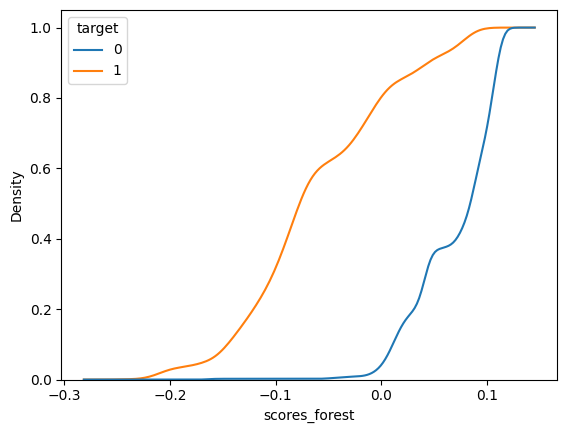

In [51]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93   5156118
           1       0.91      0.81      0.86   2620165

    accuracy                           0.91   7776283
   macro avg       0.91      0.88      0.90   7776283
weighted avg       0.91      0.91      0.91   7776283

Gini:  0.7696444294261284
ROC AUC::  0.8848222147130642


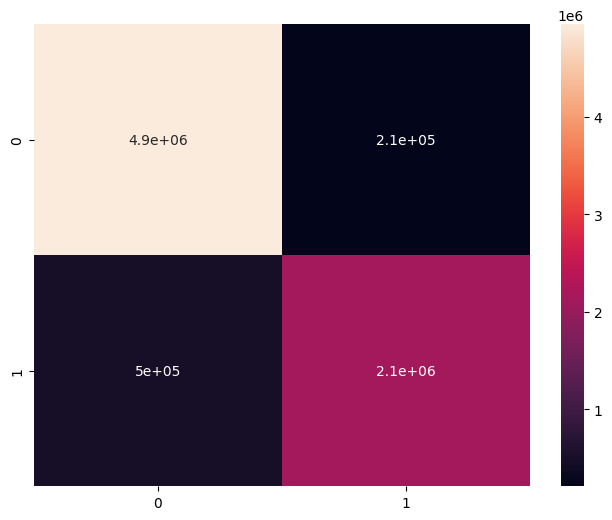

In [52]:
metrics(train.target, train.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93   2209766
           1       0.91      0.81      0.86   1122928

    accuracy                           0.91   3332694
   macro avg       0.91      0.88      0.90   3332694
weighted avg       0.91      0.91      0.91   3332694

Gini:  0.7699547064675547
ROC AUC::  0.8849773532337774


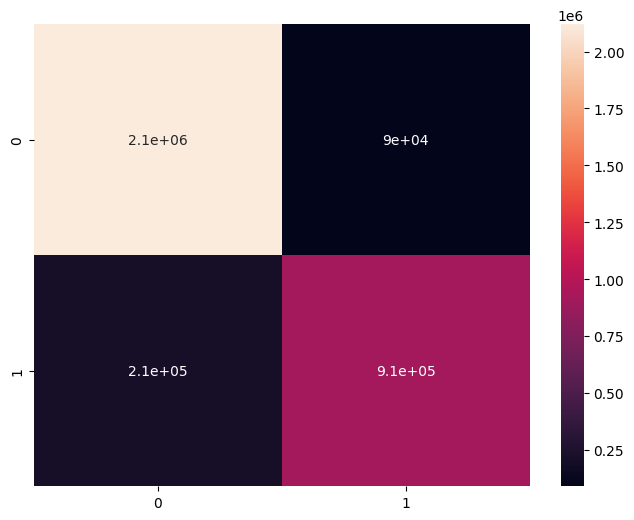

In [53]:
metrics(test.target, test.iForest)

In [54]:
with open('./models/iForest.pkl', 'wb') as file: 
    pickle.dump(iforest, file)

#### Explainable

In [55]:
import shap

In [56]:
test_sample = test[VARS].sample(frac=0.005)
test_sample.shape

(16663, 7)

In [57]:
test_sample.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
1295146,0.181717,-0.070264,-1.000363,0.454446,-1.339250,-0.227239,-0.367398
200068,0.181717,-0.066474,0.388339,0.440264,-0.160755,-0.258987,-0.367398
50249,0.181717,-0.060585,-2.278600,0.381802,-1.299921,3.828489,2.697727
215539,0.181717,-0.060115,-2.269701,0.373079,-1.254826,3.830765,2.624035
2635183,0.181717,-0.032750,0.385104,2.125317,-0.392986,-0.261320,-0.367398


In [58]:
exp = shap.TreeExplainer(iforest) #Explainer
shap_values = exp.shap_values(test_sample)  #Calculate SHAP values
shap.initjs()

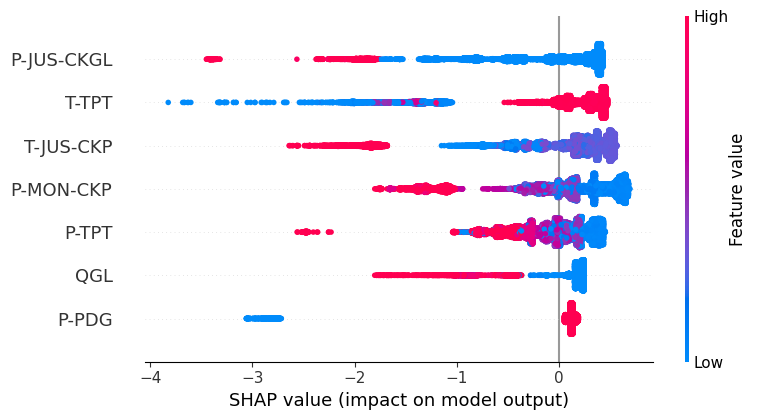

In [59]:
shap.summary_plot(shap_values, test_sample)

In [60]:
# shap.summary_plot(shap_values, test_sample,plot_type="bar")

In [61]:
shap.force_plot(exp.expected_value, shap_values[1],features =test_sample.iloc[1,:] ,feature_names =test_sample.columns)

In [62]:
# shap.bar_plot(shap_values[3],features =test_sample.iloc[3,:] ,feature_names =test_sample.columns)

### Algorithms Pyod

#### PCA

In [63]:
clf_PCA = PCA(n_components=None, n_selected_components=None, contamination=0.3, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None, weighted=True, standardization=True)
clf_PCA.fit(train[VARS])

PCA(contamination=0.3, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [64]:
test['score_PCA']= clf_PCA.decision_function(test[VARS])

In [65]:
test['PCA']=clf_PCA.predict(test[VARS])

In [66]:
train['PCA']=clf_PCA.predict(train[VARS])

In [67]:
test['PCA'].value_counts()

PCA
0    2333318
1     999376
Name: count, dtype: int64

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88   2209766
           1       0.79      0.70      0.74   1122928

    accuracy                           0.84   3332694
   macro avg       0.82      0.80      0.81   3332694
weighted avg       0.83      0.84      0.83   3332694

Gini:  0.6079040508507412
ROC AUC::  0.8039520254253706


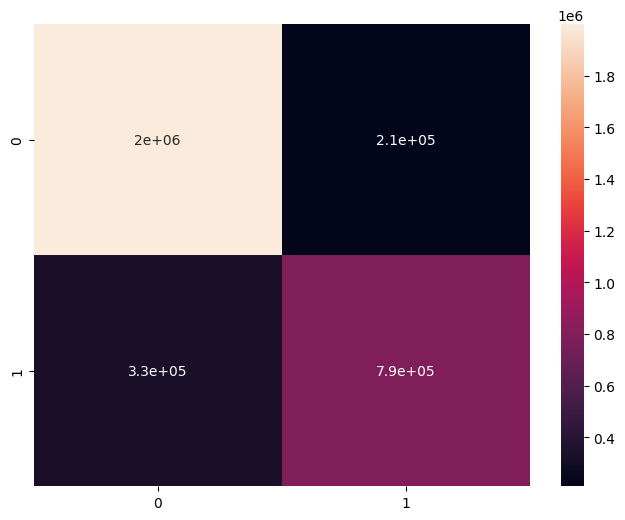

In [68]:
metrics(test.target, test.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88   5156118
           1       0.79      0.70      0.74   2620165

    accuracy                           0.84   7776283
   macro avg       0.82      0.80      0.81   7776283
weighted avg       0.83      0.84      0.83   7776283

Gini:  0.6072792624731083
ROC AUC::  0.8036396312365541


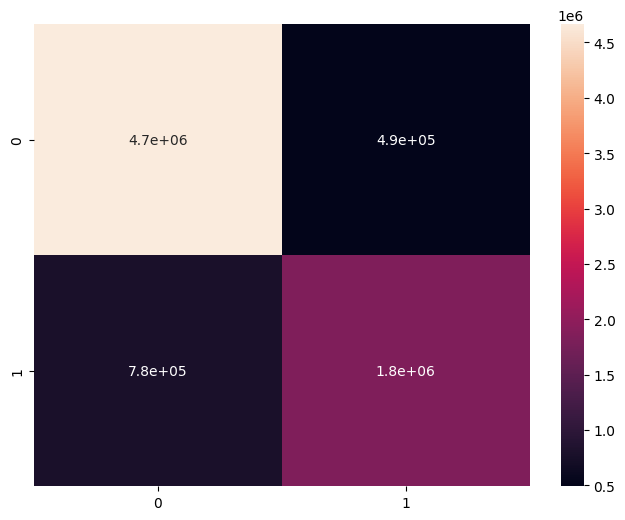

In [69]:
metrics(train.target, train.PCA)

In [70]:
with open('./models/PCA.pkl', 'wb') as file: 
    pickle.dump(clf_PCA, file)

#### LODA

In [39]:
clf_LODA = LODA(contamination=0.3, n_bins=1000, n_random_cuts=1000)
clf_LODA.fit(train[VARS])

LODA(contamination=0.3, n_bins=1000, n_random_cuts=1000)

In [40]:
# y_train_scores_loda = clf_LODA.decision_scores_  # Outlier scores for training data
test['score_LODA']= clf_LODA.decision_function(test[VARS])  # Outlier scores for test data

In [41]:
test['LODA']=clf_LODA.predict(test[VARS])

In [42]:
train['LODA']=clf_LODA.predict(train[VARS])

In [43]:
test['LODA'].value_counts()

LODA
0    2333930
1     998764
Name: count, dtype: int64

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82   5156118
           1       0.64      0.57      0.60   2620165

    accuracy                           0.75   7776283
   macro avg       0.72      0.70      0.71   7776283
weighted avg       0.74      0.75      0.74   7776283

Specificity: 0.8378710494988671
Gini:  0.4091820165562854
ROC AUC::  0.7045910082781427


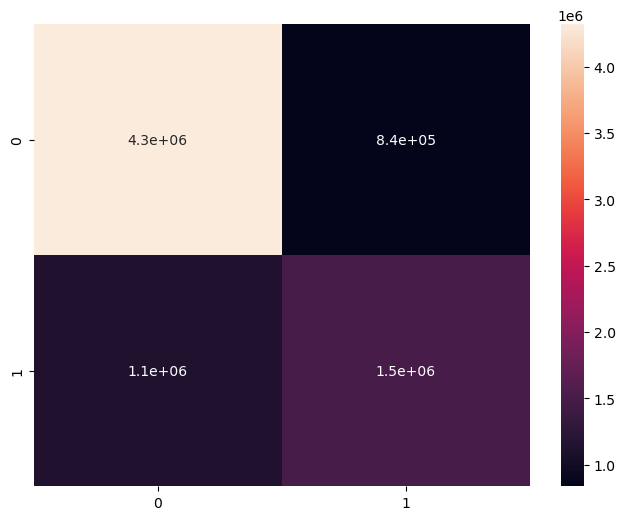

In [48]:
metrics(train.target, train.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82   2209766
           1       0.64      0.57      0.60   1122928

    accuracy                           0.75   3332694
   macro avg       0.72      0.70      0.71   3332694
weighted avg       0.74      0.75      0.74   3332694

Specificity: 0.8382086610075455
Gini:  0.4092541777281189
ROC AUC::  0.7046270888640594


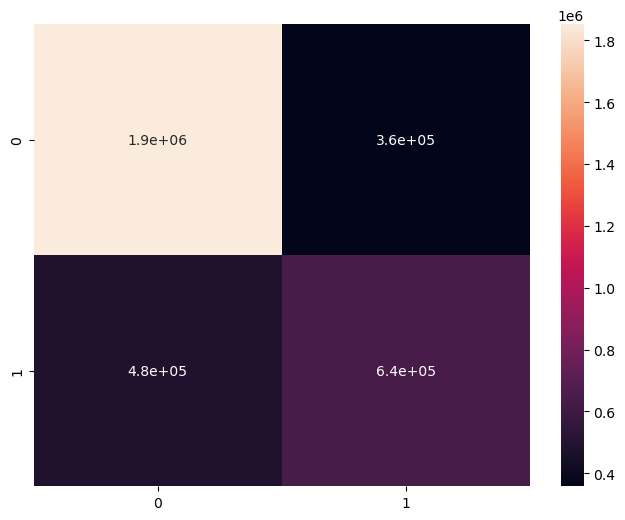

In [49]:
metrics(test.target, test.LODA)

In [46]:
# filename= './models/LODA.sav'
# joblib.dump(clf_LODA, filename)

with open('./models/LODA.pkl', 'wb') as file: 
    pickle.dump(clf_LODA, file)

### Local Outlier Factor

In [14]:
from sklearn.neighbors import LocalOutlierFactor

In [15]:
lof = LocalOutlierFactor(n_neighbors=7, novelty=True, p=2, metric = 'minkowski', contamination=0.3)
lof.fit(train[VARS])

LocalOutlierFactor(contamination=0.3, n_neighbors=7, novelty=True)

In [17]:
with open('./models/LOF.pkl', 'wb') as file: 
    pickle.dump(lof, file)

In [18]:
test['LOF']=lof.predict(test[VARS])
test['score_LOF']=lof.decision_function(test[VARS])
test['LOF'] = test['LOF'].apply(lambda x: 1 if x<0 else 0)

In [ ]:
train['LOF']=lof.predict(train[VARS])
train['score_LOF']=lof.decision_function(train[VARS])
train['LOF'] = train['LOF'].apply(lambda x: 1 if x<0 else 0)

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.82      0.74   5156118
           1       0.38      0.22      0.27   2620165

    accuracy                           0.62   7776283
   macro avg       0.52      0.52      0.51   7776283
weighted avg       0.57      0.62      0.58   7776283

Gini:  0.034475048427541566
ROC AUC::  0.5172375242137708


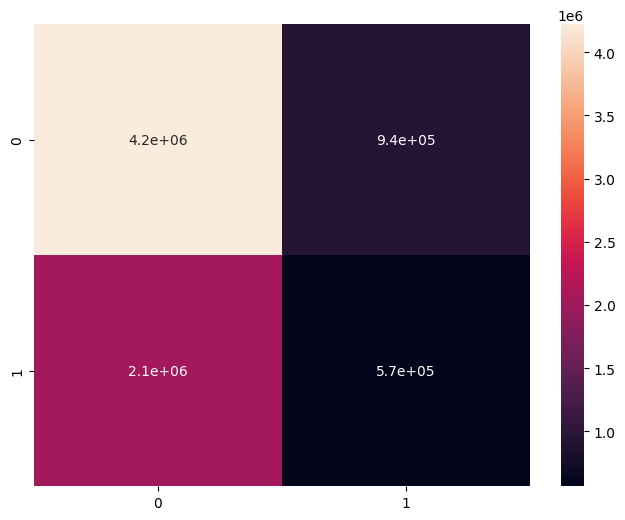

In [ ]:
metrics(train.target, train.LOF)

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.62      0.65   2209766
           1       0.37      0.43      0.40   1122928

    accuracy                           0.56   3332694
   macro avg       0.52      0.53      0.52   3332694
weighted avg       0.58      0.56      0.56   3332694

Gini:  0.05099436940535318
ROC AUC::  0.5254971847026766


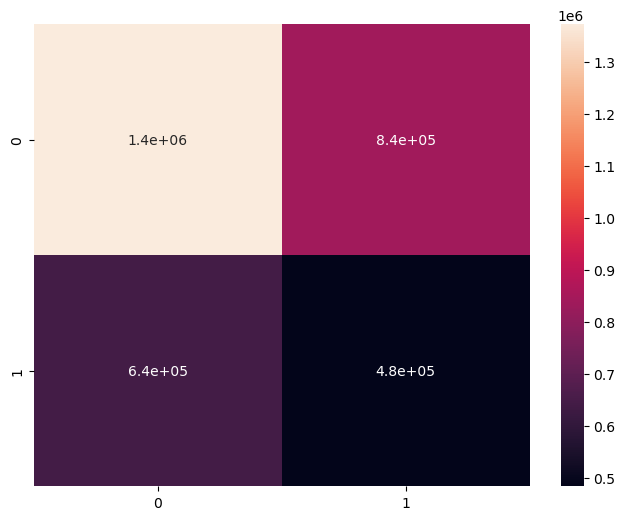

In [19]:
metrics(test.target, test.LOF)

In [ ]:
# filename= './models/LOF.sav'
# joblib.dump(lof, filename)


with open('./models/LOF.pkl', 'wb') as file: 
    pickle.dump(lof, file)